In [1]:
import sys
sys.path.insert(0, "../")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm

from src.metrics import *
from src.metrics import eval_plugin
from src.synthesizer import fit_ctgan
from src.utils import *

seed = 0
seed_everything(seed)

dataset_name = "adult"


/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from src.data_loader import load_adult_data

dataset_name = "adult"
X_train, X_oracle, y_train, y_test, X, y = load_adult_data()

Data = X
Data["y"] = y

column_metric = "race"
testsize = 0.65

In [3]:
X_train, X_test = train_test_split(Data, test_size=testsize, random_state=seed)

X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=seed)

X_train, X_hp = train_test_split(X_train, test_size=0.1, random_state=seed)


In [4]:
groups = list(Data[column_metric].unique())
for group in groups:
    print(group, X_val[X_val[column_metric] == group].shape)


0 (1838, 12)
3 (167, 12)
2 (66, 12)
1 (22, 12)
4 (19, 12)


In [5]:
discrete_columns = [
    "education-num",
    "marital-status",
    "employment_type",
    "relationship",
    "race",
    "sex",
    "country",
    "y",
]

best_params = {"learning_rate": 0.0002, "embedding_dim": 256, "epochs": 300}
ctgan = fit_ctgan(
    data=X_test,
    epochs=best_params["epochs"],
    learning_rate=best_params["learning_rate"],
    embedding_dim=best_params["embedding_dim"],
    seed=seed,
    discrete_columns=discrete_columns,
)



In [6]:
# Assuming Data[column_metric] is a series in a DataFrame called Data
groups = list(np.unique(Data[column_metric]))

max_size = 0
min_size = float("inf")
max_group = None
min_group = None

for group in groups:
    size = X_val[X_val[column_metric] == group].shape[0]
    print(group, size)
    if size > max_size:
        max_size = size
        max_group = group
    if size < min_size and size > 0:  # Skip over groups where size is zero
        min_size = size
        min_group = group

print("Biggest group:", max_group, "with size", max_size)
print("Smallest group:", min_group, "with size", min_size)


0 1838
1 22
2 66
3 167
4 19
Biggest group: 0 with size 1838
Smallest group: 4 with size 19


In [7]:
shift_df, _ = ctgan.sample(
    1, shift=False, condition_column=column_metric, condition_value=group
)
total_samples = len(X_test)
n_samples = 100


count = 0
while shift_df.shape[0] <= total_samples:

    generated_tmp, _ = ctgan.sample(
        100, shift=False
    )  

    tmp_df = generated_tmp  # [generated_tmp[column_metric]==group]

    shift_df = shift_df.append(tmp_df)
    count += 1


In [8]:
from openTSNE import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

perplexity = 20

# standardize the data and get embedding
scaler = StandardScaler()
scaler.fit(X_test)

train_sc = scaler.transform(X_test)
test_sc = scaler.transform(shift_df)
val_sc = scaler.transform(X_val)

pca = PCA(n_components=2)
pcs_train = pca.fit_transform(train_sc)
pcs_test = pca.transform(test_sc)
pcs_val = pca.transform(val_sc)

tsne = TSNE(
    perplexity=perplexity,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)

%time embedding_train = tsne.fit(train_sc)
%time embedding_test = embedding_train.transform(test_sc)
%time embedding_val = embedding_train.transform(val_sc)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=8, perplexity=20, random_state=42,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 60 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 1.29 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.08 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=12.00, lr=1633.83 for 250 iterations...
Iteration   50, KL divergence 4.3277, 50 iterations in 0.5079 sec
Iteration  100, KL divergence 3.9236, 50 iterations in 0.4881 sec
Iteration  150, KL divergence 3.6195, 50 iterations in 0.4833 sec
Iteration  200, KL divergence 3.4574, 50 iterations in 0.4828 sec
Iteration  250, KL divergence 3.3493, 50 iterations in 0.4803 sec
   --> Time elapsed: 2.44 seconds
===> Running optimization

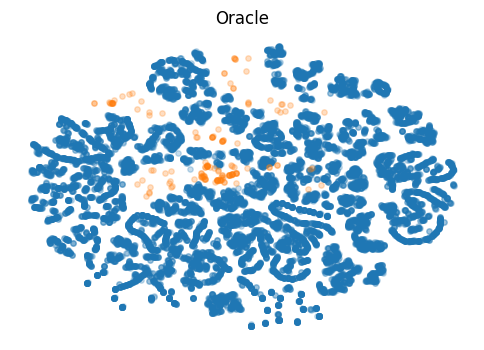

In [12]:
import matplotlib.pyplot as plt

big_ids = X_test[column_metric] == max_group
small_ids = X_test[column_metric] == min_group

size = 15
alpha = 0.25


# plt.title('Oracle')
plt.figure(figsize=(6, 4))
plt.axis("off")
plt.scatter(
    embedding_train[big_ids, 0], embedding_train[big_ids, 1], s=size, alpha=alpha
)
plt.scatter(
    embedding_train[small_ids, 0], embedding_train[small_ids, 1], s=size, alpha=alpha
)
plt.title('Oracle')
plt.show()


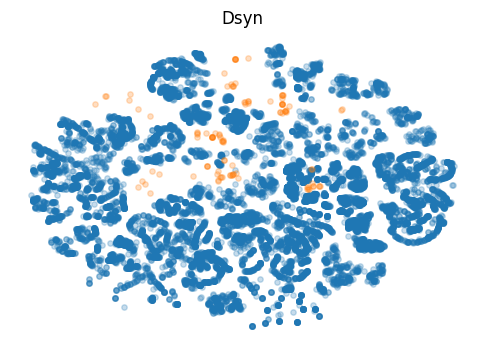

In [13]:
big_ids = shift_df[column_metric] == max_group
small_ids = shift_df[column_metric] == min_group

plt.figure(figsize=(6, 4))
plt.axis("off")
# plt.title('Dsyn')
plt.scatter(embedding_test[big_ids, 0], embedding_test[big_ids, 1], s=size, alpha=alpha)
plt.scatter(
    embedding_test[small_ids, 0], embedding_test[small_ids, 1], s=size, alpha=alpha
)
plt.title('Dsyn')
plt.show()


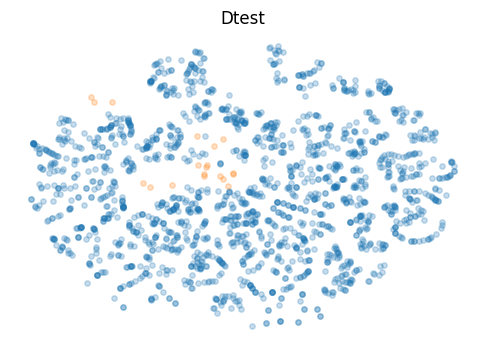

In [14]:
big_ids = X_val[column_metric] == max_group
small_ids = X_val[column_metric] == min_group

plt.figure(figsize=(6, 4))
plt.axis("off")
# plt.title('Dtest')
plt.scatter(embedding_val[big_ids, 0], embedding_val[big_ids, 1], s=size, alpha=alpha)
plt.scatter(
    embedding_val[small_ids, 0], embedding_val[small_ids, 1], s=size, alpha=alpha
)
plt.title('Dtest')
plt.show()
